# **Part A**
Count / Frequency based Naive Bayes Classifier

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score
)

# =======================================================
# TODO: Students must implement the following steps:
# 1. Complete the fit method in NaiveBayesClassifier (4 TODOs for log prior and log likelihood calculation).
# 2. Complete the predict method in NaiveBayesClassifier (2 TODOs for log probability accumulation and final argmax).
# 3. Complete the data loading calls in Section 2.
# 4. Initialize CountVectorizer with proper parameters in Section 3a.
# 5. Complete the feature transformation (fit_transform and transform) in Section 3a.
# 6. Initialize and fit the custom nb_model in Section 3b.
# 7. Use the fitted nb_model to generate predictions in Section 4.
# =======================================================


# Data loading function (DO NOT CHANGE)
def load_pubmed_rct_file(filepath):
    """
    Reads a .txt file from the PubMed 20k RCT dataset.
    Returns a DataFrame with 'label' and 'sentence'.
    """
    labels, sentences = [], []
    with open(filepath, 'r', encoding='utf-8') as f:
        for line in f:
            line = line.strip()
            if not line or '\t' not in line:
                continue
            label, sent = line.split('\t', maxsplit=1)
            labels.append(label)
            sentences.append(sent)
    return pd.DataFrame({'label': labels, 'sentence': sentences})


# Implementing Multinomial Naive Bayes from scratch
class NaiveBayesClassifier:
    """
    Multinomial Naive Bayes Classifier implemented from scratch.
    It is suitable for both Count and TF-IDF features.
    """
    def __init__(self, alpha=1.0):
        self.alpha = alpha
        self.class_priors = {}
        self.feature_log_probs = {}
        self.classes = None
        self.vocabulary_size = 0

    def fit(self, X_counts, y):
        y_array = y.to_numpy()
        self.classes = np.unique(y_array)
        self.vocabulary_size = X_counts.shape[1]

        for c in self.classes:
            X_c = X_counts[y_array == c]

            # Calculate the log prior and store it in self.class_priors[c]
            # Calculate Class Prior P(C): log(P(C))
            # P(C) = (Number of samples in class c) / (Total number of samples)
            self.class_priors[c] = np.log(X_c.shape[0] / X_counts.shape[0])

            feature_sum = X_c.sum(axis=0).A1
            total_mass = np.sum(feature_sum)

            # Apply Laplace smoothing (additive smoothing, alpha=1.0 default):
            # P(w_i | C) = (count(w_i, C) + alpha) / (total_words_in_C + alpha * vocab_size)

            # Calculate the numerator (with Laplace smoothing)
            numerator = feature_sum + self.alpha

            # Calculate the denominator (with Laplace smoothing)
            denominator = total_mass + self.alpha * self.vocabulary_size

            # Calculate the log likelihood (log(numerator / denominator))
            self.feature_log_probs[c] = np.log(numerator / denominator)

    def predict(self, X_counts):
        y_pred = []
        for i in range(X_counts.shape[0]):
            scores = {}

            x_i = X_counts.getrow(i)

            for c in self.classes:
                log_prob = self.class_priors[c]
                log_likelihoods = self.feature_log_probs[c]

                non_zero_indices = x_i.indices
                non_zero_data = x_i.data

                # Complete the log probability calculation for the likelihood term
                # Add log likelihoods contribution (Log-Sum Trick):
                # log_prob += sum(count(w_i) * log(P(w_i|C)))

                log_prob += np.sum(non_zero_data * log_likelihoods[non_zero_indices])
                scores[c] = log_prob

            # Find the key (class label) with the maximum score
            predicted_class = max(scores, key=scores.get)

            y_pred.append(predicted_class)

        # Return the final predictions array
        return np.array(y_pred)


In [2]:
# Load and Prepare Data (DO NOT CHANGE)
dir_path = './Dataset'
try:
    train_df = load_pubmed_rct_file(os.path.join(dir_path, 'train.txt'))
    dev_df   = load_pubmed_rct_file(os.path.join(dir_path, 'dev.txt'))
    test_df  = load_pubmed_rct_file(os.path.join(dir_path, 'test.txt'))

    # Comment out these placeholder lines - they override the actual data!
    # train_df = pd.DataFrame({'label': ['BACKGROUND'], 'sentence': ['placeholder']})
    # dev_df   = pd.DataFrame({'label': ['BACKGROUND'], 'sentence': ['placeholder']})
    # test_df  = pd.DataFrame({'label': ['BACKGROUND'], 'sentence': ['placeholder']})


    print(f"Train samples: {len(train_df)}")
    print(f"Dev   samples: {len(dev_df)}")
    print(f"Test  samples: {len(test_df)}")

    X_train, y_train = train_df['sentence'], train_df['label']
    X_dev,   y_dev   = dev_df['sentence'],   dev_df['label']
    X_test,  y_test  = test_df['sentence'],  test_df['label']
    target_names = sorted(y_train.unique())
    print(f"Classes: {target_names}")

except FileNotFoundError as e:
    print(f"Error: Dataset file not found. Please ensure the files are uploaded.")
    X_train, y_train = pd.Series([]), pd.Series([])
    X_test, y_test = pd.Series([]), pd.Series([])
    target_names = []


Train samples: 180040
Dev   samples: 30212
Test  samples: 30135
Classes: ['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS']


In [3]:
# Feature Extraction and Custom Model Training
if X_train is not None and len(X_train) > 0:

    # Initialize and fit the CountVectorizer for count-based features
    count_vectorizer = CountVectorizer(
        lowercase=True,
        strip_accents='unicode',
        stop_words='english',
        # Set appropriate ngram_range
        ngram_range=(1, 2),
        # Set appropriate min_df
        min_df=5
    )

    print("Fitting Count Vectorizer and transforming training data...")
    # Fit the vectorizer on X_train and transform
    X_train_counts = count_vectorizer.fit_transform(X_train)
    if X_train_counts is not None:
        print(f"Vocabulary size: {X_train_counts.shape[1]}")

    print("Transforming test data...")
    # Transform X_test using the fitted vectorizer
    X_test_counts = count_vectorizer.transform(X_test)


    # Train Custom Naive Bayes Classifier
    print("\nTraining the Custom Naive Bayes Classifier (from scratch)...")

    # Initialize the custom NaiveBayesClassifier
    nb_model = NaiveBayesClassifier(alpha=1.0)

    # Fit the model using X_train_counts and y_train
    nb_model.fit(X_train_counts, y_train)
    print("Training complete.")

else:
    print("Skipping feature extraction and training: Training data is empty or not loaded.")


Fitting Count Vectorizer and transforming training data...
Vocabulary size: 86557
Transforming test data...

Training the Custom Naive Bayes Classifier (from scratch)...
Training complete.


In [4]:
# Predict and evaluate on test set
print("\n=== Test Set Evaluation (Custom Count-Based Naive Bayes) ===")

# Check if model was trained
if 'nb_model' in locals() and 'X_test_counts' in locals():
    # Predict y_test_pred using X_test_counts
    y_test_pred = nb_model.predict(X_test_counts)

    if y_test_pred is not None:
        print(f"Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")
        print(classification_report(y_test, y_test_pred, target_names=target_names))
        test_f1 = f1_score(y_test, y_test_pred, average='macro')
        print(f"Macro-averaged F1 score: {test_f1:.4f}")
    else:
        print("Prediction step failed or incomplete.")
else:
    print("Cannot make predictions: Model or test data not available.")
    print("Please ensure the dataset files (train.txt, dev.txt, test.txt) are in the current directory.")



=== Test Set Evaluation (Custom Count-Based Naive Bayes) ===
Accuracy: 0.7483
              precision    recall  f1-score   support

  BACKGROUND       0.54      0.57      0.55      3621
 CONCLUSIONS       0.61      0.70      0.66      4571
     METHODS       0.83      0.85      0.84      9897
   OBJECTIVE       0.53      0.51      0.52      2333
     RESULTS       0.88      0.78      0.83      9713

    accuracy                           0.75     30135
   macro avg       0.68      0.69      0.68     30135
weighted avg       0.76      0.75      0.75     30135

Macro-averaged F1 score: 0.6809


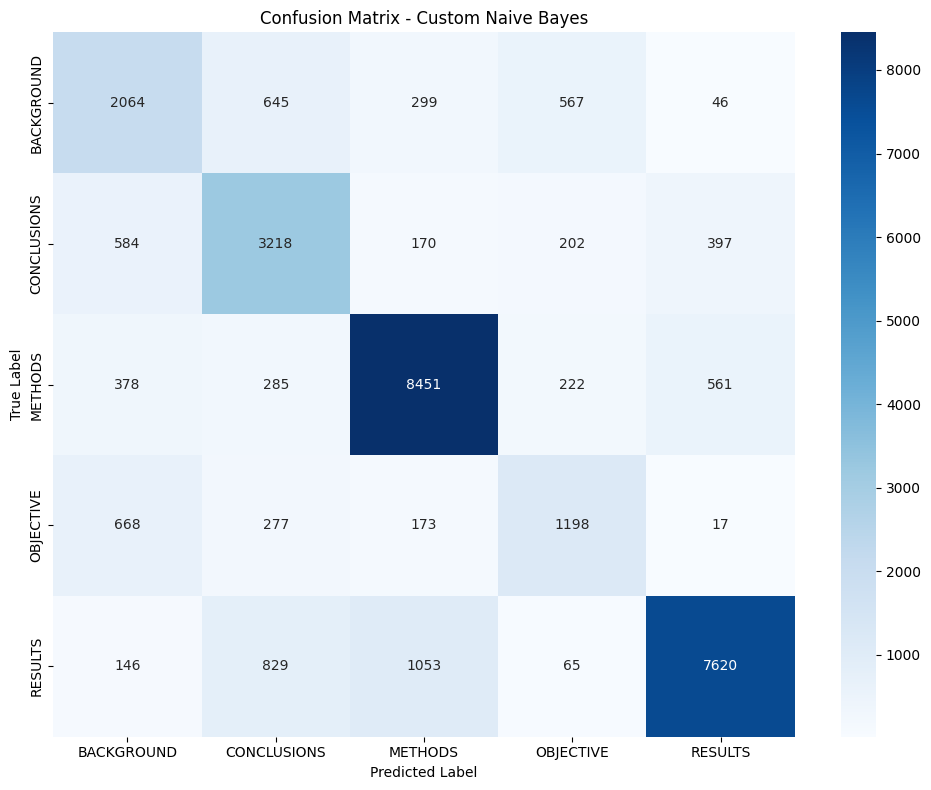

In [5]:
# Confusion Matrix on test set
if 'y_test_pred' in locals() and y_test_pred is not None:
    cm = confusion_matrix(y_test, y_test_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=target_names, yticklabels=target_names)
    plt.title('Confusion Matrix - Custom Naive Bayes')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()
else:
    print("Cannot generate confusion matrix: Predictions not available.")


# **Part B**
TF-IDF score based Classifier

In [6]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score
)

# =======================================================
# TODO: Implement the following steps:
# 1. Define the initial `pipeline` combining TfidfVectorizer and MultinomialNB with default parameters.
# 2. Train the initial pipeline on the training data (X_train, y_train).
# 3. Predict and evaluate the performance of the initial model on the test data (X_test, y_test).
# 4. Define the `param_grid` for hyperparameter tuning.
# 5. Initialize `GridSearchCV` using the pipeline, parameter grid, and appropriate cross-validation settings.
# 6. Fit the Grid Search object using the development data (X_dev, y_dev).
# 7. Print the `best_params_` and `best_score_` found by the grid search.
# =======================================================

# Check if data is available
if 'X_train' not in locals() or len(X_train) == 0:
    print("ERROR: Training data not available!")
    print("Please ensure the dataset files (train.txt, dev.txt, test.txt) are in the current directory.")
    print("Skipping Part B execution.")
else:
    # Define a Pipeline named 'pipeline' using TfidfVectorizer and MultinomialNB.
    # Use standard initial parameters
    pipeline = Pipeline([
        ('tfidf', TfidfVectorizer(lowercase=True, strip_accents='unicode', stop_words='english')),
        ('nb', MultinomialNB())
    ])

    # Train the initial pipeline on the training set
    print("Training initial Naive Bayes pipeline...")
    pipeline.fit(X_train, y_train)
    print("Training complete.")


    # Predict and evaluate on test set
    # Predict y_test_pred and calculate metrics
    print("\n=== Test Set Evaluation (Initial Sklearn Model) ===")
    y_test_pred = pipeline.predict(X_test)
    if y_test_pred is not None:
        print(f"Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")
        print(classification_report(y_test, y_test_pred, target_names=target_names))
        print(f"Macro-averaged F1 score: {f1_score(y_test, y_test_pred, average='macro'):.4f}")
        pass
    else:
        print("Initial model evaluation skipped: Predictions not available.")


    # Hyperparameter Tuning using GridSearchCV

    # Define the parameter grid 'param_grid' to tune both TF-IDF and NB parameters.
    param_grid = {
        'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],
        'tfidf__min_df': [2, 5, 10],
        'tfidf__max_df': [0.8, 0.9, 1.0],
        'nb__alpha': [0.1, 0.5, 1.0, 2.0]
    }

    # Initialize GridSearchCV using the pipeline and param_grid.
    # Ensure cv=3 and scoring='f1_macro' are used.
    grid = GridSearchCV(pipeline, param_grid=param_grid, cv=3, scoring='f1_macro', verbose=1, n_jobs=-1)

    print("\nStarting Hyperparameter Tuning on Development Set...")
    # Fit the GridSearchCV object using the development data.
    grid.fit(X_dev, y_dev)
    print("Grid search complete.")


    if grid is not None and hasattr(grid, 'best_params_'):
        # Print the best parameters and the corresponding best cross-validation score.
        print(f"\nBest Parameters: {grid.best_params_}")
        print(f"Best Cross-Validation F1 Score: {grid.best_score_:.4f}")
        
        # Evaluate the best model on test set
        print("\n=== Test Set Evaluation (Tuned Model) ===")
        y_test_pred_tuned = grid.predict(X_test)
        print(f"Accuracy: {accuracy_score(y_test, y_test_pred_tuned):.4f}")
        print(classification_report(y_test, y_test_pred_tuned, target_names=target_names))
        print(f"Macro-averaged F1 score: {f1_score(y_test, y_test_pred_tuned, average='macro'):.4f}")
    else:
        print("Hyperparameter tuning skipped: Grid Search object not initialized or fitted.")


Training initial Naive Bayes pipeline...
Training complete.

=== Test Set Evaluation (Initial Sklearn Model) ===
Accuracy: 0.6996
              precision    recall  f1-score   support

  BACKGROUND       0.61      0.37      0.46      3621
 CONCLUSIONS       0.61      0.55      0.57      4571
     METHODS       0.68      0.88      0.77      9897
   OBJECTIVE       0.72      0.09      0.16      2333
     RESULTS       0.77      0.85      0.81      9713

    accuracy                           0.70     30135
   macro avg       0.68      0.55      0.56     30135
weighted avg       0.69      0.70      0.67     30135

Macro-averaged F1 score: 0.5555

Starting Hyperparameter Tuning on Development Set...
Fitting 3 folds for each of 108 candidates, totalling 324 fits
Grid search complete.

Best Parameters: {'nb__alpha': 0.1, 'tfidf__max_df': 0.8, 'tfidf__min_df': 5, 'tfidf__ngram_range': (1, 3)}
Best Cross-Validation F1 Score: 0.6308

=== Test Set Evaluation (Tuned Model) ===
Accuracy: 0.7198
  

# **Part C**
Bayes Optimal Classifier

Part C Draft

PES2UG23CS137
Using dynamic sample size: 10137
Actual sampled training set size used: 10137

Training all base models...
Training NaiveBayes...
NaiveBayes training complete.
Training LogisticRegression...


c:\Users\raghu\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\raghu\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(


LogisticRegression training complete.
Training RandomForest...
RandomForest training complete.
Training DecisionTree...
DecisionTree training complete.
Training KNN...
KNN training complete.
All base models trained.
NaiveBayes validation log-likelihood: -1611.6336
LogisticRegression validation log-likelihood: -1446.9142
RandomForest validation log-likelihood: -1672.2922
DecisionTree validation log-likelihood: -2420.7089
KNN validation log-likelihood: -2608.8533

Posterior Weights P(h_i | D):
NaiveBayes: 0.0000
LogisticRegression: 1.0000
RandomForest: 0.0000
DecisionTree: 0.0000
KNN: 0.0000

Fitting the VotingClassifier (BOC approximation)...
Fitting complete.

Predicting on test set...

=== Final Evaluation: Bayes Optimal Classifier (Soft Voting) ===
Accuracy: 0.7080
Macro-averaged F1 score: 0.6134

Classification Report:
              precision    recall  f1-score   support

  BACKGROUND       0.56      0.36      0.44      3621
 CONCLUSIONS       0.60      0.56      0.58      4571
   

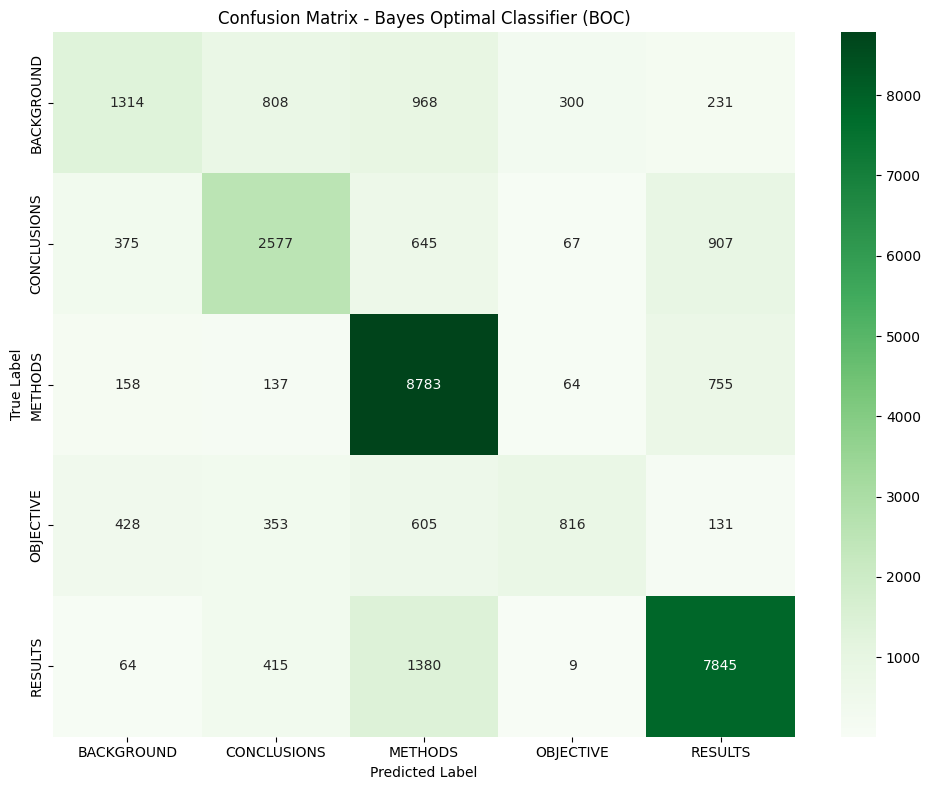


=== Individual Model Performances on Test Set ===
NaiveBayes: Accuracy = 0.7003, F1 = 0.6212
LogisticRegression: Accuracy = 0.7080, F1 = 0.6134
RandomForest: Accuracy = 0.6386, F1 = 0.5336
DecisionTree: Accuracy = 0.4869, F1 = 0.2775
KNN: Accuracy = 0.3593, F1 = 0.1748


In [8]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split # Used for P(h|D) calculation

# =======================================================
# TODO: Implement the following steps:
# 1. Train all five hypotheses on the sampled training data.
# 2. Compute the Posterior Weights P(h_i | D) using a validation split.
# 3. Fit the VotingClassifier using the sampled training data.
# 4. Make final predictions and evaluate the BOC performance on the test data.
# =======================================================

# Dynamic Data Sampling (DO NOT CHANGE)
BASE_SAMPLE_SIZE = 10000

# Prompt the user for their full SRN
FULL_SRN = input("Please enter your full SRN (e.g., PES1UG22CS345): ")
print(FULL_SRN)
try:
    # Extract the last three characters and convert to integer
    if len(FULL_SRN) >= 3:
        srn_suffix_str = FULL_SRN[-3:]
        srn_value = int(srn_suffix_str)
    else:
        # Fallback if input is too short
        raise ValueError("SRN too short.")
except (ValueError, IndexError, TypeError):
    # Fallback if SRN is not entered or format is incorrect
    print("WARNING: SRN input failed or format is incorrect. Using 10000.")
    srn_value = 0

# Calculate the final sample size: 10000 + last three SRN digits
SAMPLE_SIZE = BASE_SAMPLE_SIZE + srn_value

print(f"Using dynamic sample size: {SAMPLE_SIZE}")

# Placeholder initialization in case data wasn't loaded in the environment
if 'X_train' not in locals() or len(X_train) == 0:
    print("Warning: Training data not found. Using small placeholder data.")
    X_train = pd.Series(["sample text one"] * 11000)
    y_train = pd.Series(["BACKGROUND"] * 5000 + ["METHODS"] * 6000)
    X_test = pd.Series(["test text one", "test text two"])
    y_test = pd.Series(["BACKGROUND", "METHODS"])
    target_names = ["BACKGROUND", "CONCLUSIONS", "METHODS", "OBJECTIVE", "RESULTS"]

effective_sample_size = min(SAMPLE_SIZE, len(X_train))
X_train_sampled = X_train[:effective_sample_size]
y_train_sampled = y_train[:effective_sample_size]
print(f"Actual sampled training set size used: {effective_sample_size}")


# Base TF-IDF parameters (DO NOT CHANGE)
tfidf_params = {
    'lowercase': True,
    'strip_accents': 'unicode',
    'stop_words': 'english',
    'ngram_range': (1, 1), # Using unigrams only to keep feature space small for diverse models
    'min_df': 5
}

# Define the five diverse hypotheses/pipelines (DO NOT CHANGE)

# H1: Multinomial Naive Bayes
h1_nb = Pipeline([
    ('tfidf', TfidfVectorizer(**tfidf_params)),
    ('clf', MultinomialNB(alpha=1.0, fit_prior=False))
])

# H2: Logistic Regression
h2_lr = Pipeline([
    ('tfidf', TfidfVectorizer(**tfidf_params)),
    ('clf', LogisticRegression(solver='liblinear', multi_class='auto', max_iter=1000, random_state=42))
])

# H3: Random Forest Classifier
h3_rf = Pipeline([
    ('tfidf', TfidfVectorizer(**tfidf_params)),
    ('clf', CalibratedClassifierCV(
        RandomForestClassifier(n_estimators=50, max_depth=10, random_state=42, n_jobs=-1), cv=3, method='isotonic'
    ))
])

# H4: Decision Tree Classifier
h4_dt = Pipeline([
    ('tfidf', TfidfVectorizer(**tfidf_params)),
    ('clf', CalibratedClassifierCV(
        DecisionTreeClassifier(max_depth=10, random_state=42), cv=3, method='isotonic'
    ))
])

# H5: K-Nearest Neighbors
h5_knn = Pipeline([
    ('tfidf', TfidfVectorizer(**tfidf_params)),
    ('clf', CalibratedClassifierCV(
        KNeighborsClassifier(n_neighbors=5, n_jobs=-1), cv=3, method='isotonic'
    ))
])

hypotheses = [h1_nb, h2_lr, h3_rf, h4_dt, h5_knn]
hypothesis_names = ['NaiveBayes', 'LogisticRegression', 'RandomForest', 'DecisionTree', 'KNN']


# Training and BOC Implementation (STUDENT TASK)

# Train all five hypotheses on X_train_sampled and y_train_sampled using a for loop.
print("\nTraining all base models...")

for i, (model, name) in enumerate(zip(hypotheses, hypothesis_names)):
    print(f"Training {name}...")
    model.fit(X_train_sampled, y_train_sampled)
    print(f"{name} training complete.")

print("All base models trained.")


# Implement the Posterior Weight Calculation (P(h_i | D)).
# This requires splitting X_train_sampled into a small train_sub/val_sub set
# and calculating the validation log-likelihood for each model. Normalize these to get posterior_weights.

# Split the sampled training data for posterior weight calculation
X_train_sub, X_val_sub, y_train_sub, y_val_sub = train_test_split(
    X_train_sampled, y_train_sampled, test_size=0.2, random_state=42, stratify=y_train_sampled
)

# Calculate log-likelihoods for each hypothesis on validation set
log_likelihoods = []
for i, (model, name) in enumerate(zip(hypotheses, hypothesis_names)):
    # Get predicted probabilities
    y_val_proba = model.predict_proba(X_val_sub)
    
    # Calculate log-likelihood: sum of log probabilities for true classes
    true_class_indices = [list(model.classes_).index(true_class) for true_class in y_val_sub]
    log_likelihood = np.sum(np.log(y_val_proba[range(len(y_val_sub)), true_class_indices] + 1e-10))
    
    log_likelihoods.append(log_likelihood)
    print(f"{name} validation log-likelihood: {log_likelihood:.4f}")

# Convert log-likelihoods to posterior weights using softmax
log_likelihoods = np.array(log_likelihoods)
# Normalize using log-sum-exp trick to avoid numerical issues
max_ll = np.max(log_likelihoods)
exp_ll = np.exp(log_likelihoods - max_ll)
posterior_weights = exp_ll / np.sum(exp_ll)

print("\nPosterior Weights P(h_i | D):")
for name, weight in zip(hypothesis_names, posterior_weights):
    print(f"{name}: {weight:.4f}")


# Implement and Evaluate the Bayes Optimal Classifier
estimators = list(zip(hypothesis_names, hypotheses))

# BOC is approximated using soft voting with posterior weights
boc_soft_voter = VotingClassifier(
    estimators=estimators,
    voting='soft',
    weights=posterior_weights,
    n_jobs=-1
)

print("\nFitting the VotingClassifier (BOC approximation)...")
# Fit the VotingClassifier using the full sampled training data (X_train_sampled, y_train_sampled)
boc_soft_voter.fit(X_train_sampled, y_train_sampled)
print("Fitting complete.")


# Make the final BOC prediction on the test set
print("\nPredicting on test set...")
# Predict y_pred using X_test, and then calculate and visualize evaluation metrics.
y_pred = boc_soft_voter.predict(X_test)


# Final Evaluation (STUDENT TASK)
print("\n=== Final Evaluation: Bayes Optimal Classifier (Soft Voting) ===")

if y_pred is not None:
    # Calculate and print metrics
    accuracy = accuracy_score(y_test, y_pred)
    f1_macro = f1_score(y_test, y_pred, average='macro')
    
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Macro-averaged F1 score: {f1_macro:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=target_names))
    
    # Generate and visualize the Confusion Matrix (heatmap) for the BOC predictions.
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', 
                xticklabels=target_names, yticklabels=target_names)
    plt.title('Confusion Matrix - Bayes Optimal Classifier (BOC)')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()
    
    # Compare individual model performances
    print("\n=== Individual Model Performances on Test Set ===")
    for model, name in zip(hypotheses, hypothesis_names):
        y_pred_individual = model.predict(X_test)
        acc = accuracy_score(y_test, y_pred_individual)
        f1 = f1_score(y_test, y_pred_individual, average='macro')
        print(f"{name}: Accuracy = {acc:.4f}, F1 = {f1:.4f}")
else:
    print("Evaluation skipped: Predictions not generated.")
